# **TASK 1: Acquire the data**

In [ ]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
import pandas as pd
from copy import deepcopy


loading the data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

4422102/4422102 [==============================] - 0s 0us/step
x_train: (60000, 28, 28)
x_test: (10000, 28, 28)
y_train: (60000,)
y_test: (10000,)


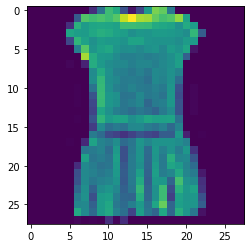

In [ ]:
plt.figure()
plt.imshow(x_train[3])
plt.show()

In [ ]:
# create validation set

indices = np.zeros((10000,), dtype=int)
x_val = np.zeros((10000, 28, 28))
y_val = np.zeros((10000,))
for i in range(10):
    class_indices = np.where(y_train == i)[0]
    indices[i*1000:(i+1)*1000] = np.random.choice(class_indices[:], 1000, replace=False)
x_val = deepcopy(x_train[indices])
y_val = deepcopy(y_train[indices])
x_train = np.delete(x_train, indices, axis=0) # remove validation set from x_train
y_train = np.delete(y_train, indices, axis=0) # remove validation set from y_train


In [ ]:
print(f"x_train: {x_train.shape}")
print(f"x_val: {x_val.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")

x_train: (50000, 28, 28)
x_val: (10000, 28, 28)
x_test: (10000, 28, 28)
y_train: (50000,)
y_val: (10000,)
y_test: (10000,)


In [ ]:
#flatten the data
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_val = x_val.reshape((x_val.shape[0],x_val.shape[1]*x_val.shape[2]))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
print(f"x_train: {x_train.shape}")
print(f"x_val: {x_val.shape}")
print(f"x_test: {x_test.shape}")

x_train: (50000, 784)
x_val: (10000, 784)
x_test: (10000, 784)


In [ ]:
#Normalization
x_mean_train = np.mean(x_train, axis=1).reshape(50000,1)
x_mean_val = np.mean(x_val, axis=1).reshape(10000,1)
x_mean_test = np.mean(x_test, axis=1).reshape(10000,1)
x_std_train = np.std(x_train, axis =1).reshape(50000,1)
x_std_val = np.std(x_val, axis =1).reshape(10000,1)
x_std_test = np.std(x_test, axis=1).reshape(10000,1)
x_train_unnorm = x_train
x_val_unnorm = x_val
x_test_unnorm = x_test
x_train = (x_train - x_mean_train)/x_std_train # subtract the mean to center the cloud of data around the origin along every dimension (the data is centered at 0)
x_val = (x_val - x_mean_val)/x_std_val
x_test = (x_test - x_mean_test)/x_std_test



In [ ]:
#convert class vectors to binary class matrices
y_train_mtx = to_categorical(y_train)
y_val_mtx = to_categorical(y_val)
y_test_mtx = to_categorical(y_test)


Exploratory Analysis: Class Distribution

In [ ]:
label = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
classes=[]
for i in range(len(y_train)):
  classes.append(label[y_train[i]])

count = pd.Series(classes[:]).value_counts()
print(count)

Ankle boot     5000
T-shirt/top    5000
Pullover       5000
Sneaker        5000
Sandal         5000
Trouser        5000
Shirt          5000
Coat           5000
Dress          5000
Bag            5000
dtype: int64


# **Task 2**

In [ ]:
def softmax(x) :
  return np.exp(x)/sum(np.exp(x))

def softmax_n(x):
  result = []
  for i in range(x.shape[0]):
    result.append(softmax(x[i]))
  return np.stack(result,axis=0)

# use softmax at last layer
class MLP:
    
    def __init__(self, M=64, layer_num=2, active_func="relu", lrelu_gamma=0.7,dropout=1): # M is number of hidden units
        self.M = M
        self.layer_num = layer_num
        self.lrelu_gamma = lrelu_gamma
        self.dropout = dropout
        
        def lrelu(x):
          temp = np.copy(x)
          for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
              if x[i][j] > 0:
                temp[i][j] = x[i][j]
              else:
                temp[i][j] = x[i][j] * self.lrelu_gamma
          return temp

        def relu(d):
          temp = np.copy(d)
          for i in range(d.shape[0]):
            for j in range(d.shape[1]):
              if d[i][j] > 0:
                temp[i][j] = d[i][j]
              else:
                temp[i][j] = 0
          return temp

        np_tanh = lambda x: np.tanh(x)

        def dlrelu(x):
          temp = np.copy(x)
          for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
              if x[i][j] > 0:
                temp[i][j] = 1
              elif x[i][j] < 0:
                temp[i][j] = self.lrelu_gamma
              else:
                temp[i][j] = 0
          return temp
            
        def drelu(x):
          temp = np.copy(x)
          for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
              if x[i][j] > 0:
                temp[i][j] = 1
              else:
                temp[i][j] = 0
          return temp

        def dtanh(x):
          return 1 - (np.tanh(x) * np.tanh(x))

        if active_func == "lrelu":
          self.acfun = lrelu
          self.dfunc = drelu
        elif active_func == "relu":
          self.acfun = relu
          self.dfunc = drelu
        elif active_func == "tanh": 
          self.acfun = np_tanh
          self.dfunc = np.vectorize(dtanh)
                    
    def fit(self, x, y, optimizer, pre_params=[], ridgeRegression=False, l2_reg=0):
        N,D = x.shape
        def gradient(x, y, params):
          dparams = []
          # has 0 hidden layer [w0]
          if len(params) == 1:
            #forward
            w0 = params[0] # D x C
            yh = softmax_n(np.dot(x,w0)) # N x D dot D x C -> N x C
            # yh = np.argmax(yh_before,axis=1)[:,None] # change from N x C -> N x 1
            dy = yh - y # N x C
            
            #backprop
            dw0 = np.dot(x.T, dy) # D x N dot N x C -> D x C
            if ridgeRegression:
                dw0 += w0*l2_reg
            dparams = [dw0] # D x C


          elif len(params) == 2: # hidden = 1
            # forward
            w0,w1 = params 
            s0 = np.dot(x,w0) # N x M
            z0 = self.acfun(s0) 
            s1 = np.dot(z0,w1) 
            yh= softmax_n(s1) 
            dy = (yh - y) 

            # backprop
            dw1 = np.dot(z0.T,dy) 
            tmp = np.dot(dy,w1.T) 
            tmp = tmp * self.dfunc(s0) 
            dw0 = np.dot(x.T, tmp) 

            if ridgeRegression:
                dw0 += w0*l2_reg
                dw1 += w1*l2_reg

            dparams = [dw0,dw1] # dw0: D x M, dw1: M x C
            
          elif len(params) == 3: # hidden = 2
            # forward
            w0,w1,w2 = params 
            s0 = np.dot(x,w0) # N x D dot D x M -> N x M
            z0 = self.acfun(s0) 
            s1 = np.dot(z0,w1) # N x M dot M x M -> N x M
            z1 = self.acfun(s1) 
            s2 = np.dot(z1,w2) 
            yh = softmax_n(s2) # N x C -> N x C
            dy = (yh - y) 

            # backprop
            dw2 = np.dot(z1.T, dy) 

            term1 = np.dot(w2,dy.T) 
            term2 = self.dfunc(s1) * z0  
            dw1 = np.dot(term1,term2)  

            term1 = np.dot(dy,w2.T)  
            term2 = term1 * self.dfunc(s1)  
            term3 = np.dot(term2, w1)  
            term4 = term3 * self.dfunc(s0)  
            dw0 = np.dot(x.T,term4)  

            if ridgeRegression:
                dw0 += w0*l2_reg
                dw1 += w1*l2_reg
                dw2 += w2*l2_reg

            dparams = [dw0,dw1,dw2]
          return dparams

        M_new = int(self.M * self.dropout) + 1 # size + 1 (the bias)
        D_new = int(D * self.dropout)
        x_new = np.copy(x)
        if self.dropout < 1:
          # select randomly some features if dropout < 1
          self.drop_index = np.random.randint(D,size=D_new)
          x_new = x_new[:,self.drop_index]

        D_new += 1 # size + 1 (the bias)
        # add 1 column of random numbers to x as bias (bias is in shape N x 1)
        new_col = np.random.randn(N,1) * .01
        x_new = np.append(x_new,new_col,axis=1)
          
        # if trained based on previous params
        if pre_params != []:
          params0 = pre_params
        else:
          C = 10
          if self.layer_num == 0:
            w0 = np.random.randn(D_new,C) * .01 # D x C
            params0 = [w0]
          elif self.layer_num == 1:
            w0 = np.random.randn(D_new,M_new) * .01  
            w1 = np.random.randn(M_new,C) * .01  
            params0 = [w0,w1]
          elif self.layer_num == 2:
            w0 = np.random.randn(D_new,M_new) * .01  
            w1 = np.random.randn(M_new,M_new) * .01  
            w2 = np.random.randn(M_new,C) * .01  
            params0 = [w0,w1,w2]

        self.params, self.params_per_epoch = optimizer.run(gradient, x_new, y, params0)
        return self
    
    def predict(self, x):
      if(self.dropout < 1):
        input = x[:,self.drop_index]
      else:
        input = x

      for i in range(len(self.params)):
        if(i  == len(self.params)-1):
          input = np.dot(input,self.params[i][:-1]) # ignore the bias row when predicting
        else:
          input = self.acfun(np.dot(input,self.params[i][:-1,:-1])) 
      yh = softmax(input)
      return yh

    def evaluate_acc(self,y_pred,y_true):
       
      y_pred = np.argmax(y_pred,axis=1)
      y_true = np.argmax(y_true,axis=1)
      return np.sum(y_pred == y_true)/y_true.shape[0]

class GradientDescent:
  # default batch size 50
  def __init__(self, learning_rate=.001, max_iters=10000, epsilon=1e-8, batch_size = 50):
      self.learning_rate = learning_rate
      self.max_iters = max_iters
      self.epsilon = epsilon
      self.batch_size = batch_size
      self.epochs = 0
      
      
  def run(self, gradient_fn, x, y, params):
       
      params_per_epoch = list()
      norms = np.array([np.inf])
      t = 1
      while np.any(norms > self.epsilon) and t < self.max_iters:
         
        N,D = x.shape
        C = 10
        batch_index = np.random.randint(N,size=self.batch_size)
        x_batch = x[batch_index] # N x D
        y_batch = y[batch_index] # N x C
        grad = gradient_fn(x_batch, y_batch, params)
        for p in range(len(params)):
          params[p] -= self.learning_rate * grad[p]
        t += 1
        norms = np.array([np.linalg.norm(g) for g in grad])
        if N / (t/(self.epochs+1)) <= self.batch_size:
            self.epochs += 1
            params_copy = deepcopy(params)
            params_per_epoch.append(params_copy)

      print(f"run completed after {t} SGD batches and {self.epochs} epochs")
      return params, params_per_epoch



In [ ]:
def run_n_epochs(model, optimizer, max_epochs, result_dict=None):
    def ce(yh, y):
        log_yh = np.log(yh)
        log_yh[log_yh==-np.inf]=-1000000 # replace -inf with large negative number to allow computation.
        return -(y * log_yh).sum(axis=-1).mean()



    if result_dict == None: result_dict = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    # set params =  if model is completely untrained
    try:
        params = model.params
    except AttributeError:
        params = []
        
    for i in range(max_epochs):
        model.fit(x_train,y_train_mtx,optimizer,params)
        params = model.params

        yh_train = model.predict(x_train)
        train_acc = model.evaluate_acc(yh_train,y_train_mtx)
        train_loss = ce(yh_train, y_train_mtx)

        yh_val = model.predict(x_val)
        val_acc = model.evaluate_acc(yh_val,y_val_mtx)
        val_loss = ce(yh_val, y_val_mtx)

        result_dict['train_acc'].append(train_acc)
        result_dict['val_acc'].append(val_acc)
        result_dict['train_loss'].append(train_loss)
        result_dict['val_loss'].append(val_loss)

    return result_dict, model

# 3.1

In [ ]:
def compare_models(model_list,optimizer):
  test_acc = []
  for model in model_list:
    model.fit(x_train,y_train_mtx,optimizer)
    y_pred = model.predict(x_test)
    test_acc.append([model.evaluate_acc(y_pred,y_test_mtx)])
  return test_acc

In [ ]:
# optimizer used for all experiments
optimizer = GradientDescent(learning_rate=0.00005,max_iters=20000)
MLP_0L = MLP(layer_num=0)
MLP_1L = MLP(layer_num=1,M=128,active_func="relu")
MLP_2L = MLP(layer_num=2,M=128,active_func="relu")

# creating models
column_names = ['Test Accuracy','Activate Function','Hidden Layer','Dropout Ratio','Normalized Train Data']
model_list = [MLP_0L,MLP_1L,MLP_2L] # compare depths
acc_list = compare_models(model_list,optimizer)
acc_list[0].extend(["Relu",0,1,True])
acc_list[1].extend(["Relu",1,1,True])
acc_list[2].extend(["Relu",2,1,True])
df = pd.DataFrame(acc_list,columns=column_names)
df

run completed after 20000 SGD batches and 20 epochs
run completed after 20000 SGD batches and 20 epochs
run completed after 20000 SGD batches and 20 epochs


,Test Accuracy,Activate Function,Hidden Layer,Dropout Ratio,Normalized Train Data
0,0.8114,Relu,0,1,True
1,0.8262,Relu,1,1,True
2,0.5520,Relu,2,1,True


# 3.2

This experiment was ran at multiple learning rates to try to find an optimal learning rate for each activation function.

In [ ]:
optimizer = GradientDescent(learning_rate=0.0001,max_iters=20000)
MLP_2L_relu = MLP(layer_num=2,M=128,active_func="relu")
MLP_2L_lrelu = MLP(layer_num=2,M=128,active_func="lrelu")
MLP_2L_tanh = MLP(layer_num=2,M=128,active_func="tanh")
models_acfun = [MLP_2L_relu,MLP_2L_lrelu,MLP_2L_tanh] # compare acfuns
acc_list = compare_models(models_acfun,optimizer)
acc_list[0].extend(["Relu",2,1,True])
acc_list[1].extend(["Leaky Relu",2,1,True])
acc_list[2].extend(["Tanh",2,1,True])
column_names = ['Test Accuracy','Activate Function','Hidden Layer','Dropout Ratio','Normalized Train Data']
df2 = pd.DataFrame(acc_list,columns=column_names)
df2

run completed after 20000 SGD batches and 20 epochs
run completed after 20000 SGD batches and 20 epochs
run completed after 20000 SGD batches and 20 epochs


,Test Accuracy,Activate Function,Hidden Layer,Dropout Ratio,Normalized Train Data
0,0.5487,Relu,2,1,True
1,0.7021,Leaky Relu,2,1,True
2,0.7967,Tanh,2,1,True


# 3.3

In [ ]:
# 3.3 Trial 1
test_acc = []

optimizer = GradientDescent(learning_rate=0.00005,max_iters=10000)
model = MLP(layer_num=2,M=128,active_func="relu")
model.fit(x_train,y_train_mtx,optimizer)
y_pred = model.predict(x_test)
test_acc.append([model.evaluate_acc(y_pred,y_test_mtx), f"No l2 used"])
print(f"Control: {test_acc[0]}% accuracy")

for i, lambduh in enumerate([0.01, 0.1, 1, 10]):
    optimizer = GradientDescent(learning_rate=0.00005,max_iters=10000)
    model = MLP(layer_num=2,M=128,active_func="relu")
    model.fit(x_train,y_train_mtx,optimizer,ridgeRegression=True, l2_reg=lambduh)
    y_pred = model.predict(x_test)
    test_acc.append([model.evaluate_acc(y_pred,y_test_mtx), str(lambduh)])
    print(f"Model with lambda = {lambduh}: {test_acc[i+2]}% accuracy")

column_names = ['Test Accuracy','Lambda']
df_reg = pd.DataFrame(test_acc,columns=column_names)
df_reg

run completed after 10000 SGD batches and 10 epochs
Control: [0.7417, 'No l2 used']% accuracy
run completed after 10000 SGD batches and 10 epochs
Model with lambda = 0.01: [0.7262, '0.1']% accuracy
run completed after 10000 SGD batches and 10 epochs
Model with lambda = 0.1: [0.7416, '0.15']% accuracy
run completed after 10000 SGD batches and 10 epochs
Model with lambda = 0.5: [0.7041, '0.2']% accuracy
run completed after 10000 SGD batches and 10 epochs
Model with lambda = 1: [0.7121, '0.3']% accuracy
run completed after 10000 SGD batches and 10 epochs
Model with lambda = 10: [0.5748, '1']% accuracy
run completed after 10000 SGD batches and 10 epochs
Model with lambda = 10: [0.1, '10']% accuracy
run completed after 10000 SGD batches and 10 epochs
Model with lambda = 10: [0.1, '100']% accuracy


,Test Accuracy,Lambda
0,0.7417,No l2 used
1,0.7262,0.1
2,0.7416,0.15
3,0.7041,0.2
4,0.7121,0.3
5,0.5748,1
6,0.1000,10
7,0.1000,100


# 3.4

In [ ]:
with tf.device('/device:GPU:0'): 
    # Unnormalized Data Trial 1
    optimizer = GradientDescent(learning_rate=0.00001,max_iters=1000)
    model_unnorm = MLP(layer_num=2,M=128,active_func="relu")
    model_unnorm.fit(x_train_unnorm, y_train_mtx, optimizer)
    y_pred_unorm = model_unnorm.predict(x_test_unnorm)
    acc_unnorm=model_unnorm.evaluate_acc(y_pred_unorm,y_test_mtx)
    print(acc_unnorm)

run completed after 1000 SGD batches and 1 epochs
0.6472


In [ ]:
with tf.device('/device:GPU:0'): 
    # Unnormalized Data Trial 2
    optimizer = GradientDescent(learning_rate=0.00001,max_iters=2000)
    model_unnorm = MLP(layer_num=2,M=128,active_func="relu")
    model_unnorm.fit(x_train_unnorm, y_train_mtx, optimizer)
    y_pred_unorm = model_unnorm.predict(x_test_unnorm)
    acc_unnorm=model_unnorm.evaluate_acc(y_pred_unorm,y_test_mtx)
    print(acc_unnorm)

run completed after 2000 SGD batches and 2 epochs
0.6757


In [ ]:
# with tf.device('/device:GPU:0'): 
#     # Unnormalized Data Trial 2
#     optimizer = GradientDescent(learning_rate=0.00001,max_iters=10000)
#     model_unnorm = MLP(layer_num=2,M=128,active_func="relu")
#     model_unnorm.fit(x_train_unnorm, y_train_mtx, optimizer)
#     y_pred_unorm = model_unnorm.predict(x_test_unnorm)
#     acc_unnorm=model_unnorm.evaluate_acc(y_pred_unorm,y_test_mtx)
#     print(acc_unnorm)

# **3.5**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
import keras
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def createModel():
    model = Sequential()
  
    model.add(Conv2D(filters=32,kernel_size=(2,2),activation ="relu",input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=32,kernel_size=(2,2),activation ="relu",input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(10,activation="softmax"))
    
    return model
model1 = createModel()
model1.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model1.summary()
(x_train_1, y_train_1), (x_test_1, y_test_1) = tf.keras.datasets.fashion_mnist.load_data()
x_train_1 = np.expand_dims(x_train_1, -1)
x_test_1 = np.expand_dims(x_test_1, -1)
x_train_1 = x_train_1.astype('float32')
x_train_1 = x_train_1 / 255.

x_test_1 = x_test_1.astype('float32')
x_test_1 = x_test_1 / 255.


y_train_mtx_1 = to_categorical(y_train_1)
y_test_mtx_1 = to_categorical(y_test_1)


train_X,valid_X,train_label,valid_label = train_test_split(x_train_1, y_train_mtx_1, test_size=0.2, random_state=13)

def get_history():
    with tf.device('/device:GPU:0'): 
        history = model1.fit(train_X, train_label, batch_size=64,epochs=20,verbose=1,validation_data=(valid_X, valid_label))
    return history

history = get_history()

def eval_cnn():
    with tf.device('/device:GPU:0'): 
        test_acc = model1.evaluate(x_test_1,y_test_mtx_1)
    return test_acc

test_acc = eval_cnn()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 27, 27, 32)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 32)        4128      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1152)              0         
                                                                 
 dense_9 (Dense)             (None, 128)              

# Scratch work

In [ ]:
optimizer = GradientDescent(learning_rate=0.00005,max_iters=1000, batch_size=50) # will stop optimizing after 1 epoch
MLP_2L = MLP(layer_num=2,M=128,active_func="relu")
results_dict, trained_model = run_n_epochs(MLP_2L, optimizer, 10)
results_dict

In [ ]:
results_dict, trained_model = run_n_epochs(trained_model, optimizer, 10, results_dict)
results_dict

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24), dpi=80)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
x_axis = list(range(len(results_dict["train_loss"]) + 1)[1:])

plt.subplot(2,2,1)
plt.title("Model Loss", fontsize=20)
plt.plot(x_axis,results_dict["train_loss"],label="training loss",color="red")

plt.subplot(2,2,1)
plt.plot(x_axis,results_dict["val_loss"], markevery=[56], label="validation loss",color="green")

plt.ylabel("Loss")
plt.xlabel("Epoches")
plt.legend(loc=3, fontsize=12)



In [ ]:


plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24), dpi=80)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
x_axis = list(range(len(results_dict["train_acc"]) + 1)[1:])

plt.subplot(2,2,1)
plt.title("Model Accuracy", fontsize=20)
plt.plot(x_axis,results_dict["train_acc"],label="training accuracy",color="red")

plt.subplot(2,2,1)
plt.plot(x_axis,results_dict["val_acc"], markevery=[56], label="validation accuracy",color="green")
# plt.plot(i, acc, marker='*', color='green', label='best accuracy')

plt.ylabel("Accuracy")
plt.xlabel("Epoches")
plt.legend(loc=3, fontsize=12)



plt.show()

#Task 3.6 (Part 1 - Hyperparameter Testing)

Step 1: Check optimal number of layers (done in 3.1)

Step 2: Find optimal activation function (3.2 testing was for 2 layers)

In [ ]:
optimizer = GradientDescent(learning_rate=0.00005,max_iters=25000, batch_size=50)
MLP_1L_relu = MLP(layer_num=1,M=128,active_func="relu")
MLP_1L_lrelu = MLP(layer_num=1,M=128,active_func="lrelu")
MLP_1L_tanh = MLP(layer_num=1,M=128,active_func="tanh")
models_acfun = [MLP_1L_relu,MLP_1L_lrelu,MLP_1L_tanh] # compare acfuns
acc_list = compare_models(models_acfun,optimizer)
acc_list[0].extend(["Relu",1,1,True])
acc_list[1].extend(["Leaky Relu",1,1,True])
acc_list[2].extend(["Tanh",1,1,True])
column_names = ['Test Accuracy','Activate Function','Hidden Layer','Dropout Ratio','Normalized Train Data']
df3 = pd.DataFrame(acc_list,columns=column_names)
df3

run completed after 25000 SGD batches and 25 epochs
run completed after 25000 SGD batches and 25 epochs


In [ ]:
# opt1 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=10)
# opt2 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=20)
# opt3 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=30)
# opt4 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=40)
# opt5 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=50)
# opt6 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=60)
# opt7 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=70)
# opt8 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=80)
# opt9 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=90)
# opt10 = GradientDescent(learning_rate=0.0002,max_iters=25000, batch_size=100)
# acc_lis1 = compare_models(models_acfun,opt1)
# acc_lis2 = compare_models(models_acfun,opt2)
# acc_lis3 = compare_models(models_acfun,opt3)
# acc_lis4 = compare_models(models_acfun,opt4)
# acc_lis5 = compare_models(models_acfun,opt5)
# acc_lis6 = compare_models(models_acfun,opt6)
# acc_lis7 = compare_models(models_acfun,opt7)
# acc_lis8 = compare_models(models_acfun,opt8)
# acc_lis9 = compare_models(models_acfun,opt9)
# acc_lis10 = compare_models(models_acfun,opt10)



Affirm learning rate creates convex loss function

In [ ]:
optimizer = GradientDescent(learning_rate=0.00005,max_iters=1000, batch_size=50) # will stop optimizing after 1 epoch
MLP_1L = MLP(layer_num=1,M=128,active_func="tanh")
results_dict, trained_model = run_n_epochs(MLP_1L, optimizer, 3)
results_dict

run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs


{'train_acc': [0.68288, 0.7424, 0.77974],
 'val_acc': [0.6827, 0.7392, 0.7693],
 'train_loss': [9.588117119411361, 9.38244983563498, 9.310796480429476],
 'val_loss': [7.979226462414353, 7.777240537417383, 7.709503813089861]}

In [ ]:
results_dict, trained_model = run_n_epochs(trained_model, optimizer, 5, results_dict)
results_dict

run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs


{'train_acc': [0.68288,
  0.7424,
  0.77974,
  0.79826,
  0.80772,
  0.8144,
  0.81998,
  0.82544],
 'val_acc': [0.6827, 0.7392, 0.7693, 0.79, 0.7991, 0.8078, 0.8127, 0.8188],
 'train_loss': [9.588117119411361,
  9.38244983563498,
  9.310796480429476,
  9.27907107279672,
  9.266298535773789,
  9.261467642642398,
  9.264539068612589,
  9.2655878465337],
 'val_loss': [7.979226462414353,
  7.777240537417383,
  7.709503813089861,
  7.680446103590971,
  7.669214563385874,
  7.665386835908239,
  7.669690060932288,
  7.671459646413033]}

In [ ]:
results_dict, trained_model = run_n_epochs(trained_model, optimizer, 5, results_dict)
results_dict

run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs


{'train_acc': [0.68288,
  0.7424,
  0.77974,
  0.79826,
  0.80772,
  0.8144,
  0.81998,
  0.82544,
  0.8288,
  0.83088,
  0.83432,
  0.83776,
  0.83912],
 'val_acc': [0.6827,
  0.7392,
  0.7693,
  0.79,
  0.7991,
  0.8078,
  0.8127,
  0.8188,
  0.8215,
  0.8243,
  0.826,
  0.8293,
  0.8304],
 'train_loss': [9.588117119411361,
  9.38244983563498,
  9.310796480429476,
  9.27907107279672,
  9.266298535773789,
  9.261467642642398,
  9.264539068612589,
  9.2655878465337,
  9.271707951060408,
  9.277881041498272,
  9.28012621451997,
  9.28344862895624,
  9.289500889530759],
 'val_loss': [7.979226462414353,
  7.777240537417383,
  7.709503813089861,
  7.680446103590971,
  7.669214563385874,
  7.665386835908239,
  7.669690060932288,
  7.671459646413033,
  7.678384243252809,
  7.68579347929343,
  7.689738781570073,
  7.693548673236059,
  7.700210844179815]}

<ipython-input-41-a71628197a09>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,1)


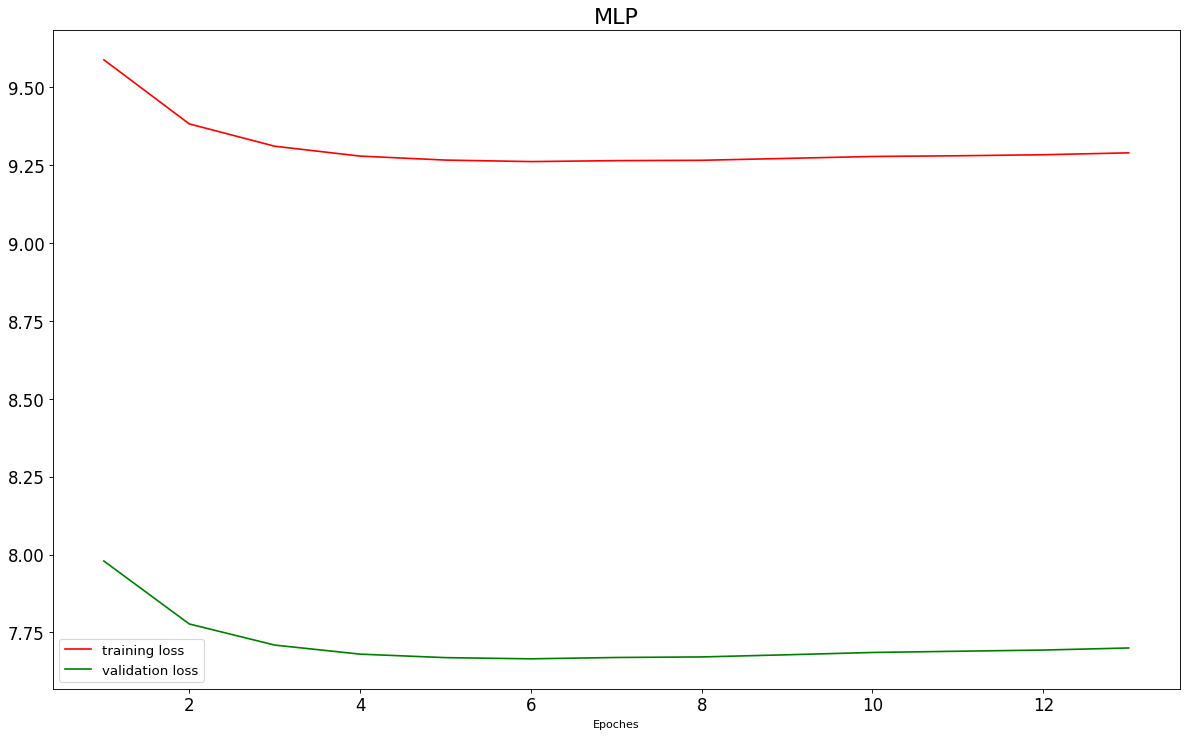

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24), dpi=80)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
x_axis = list(range(len(results_dict["train_loss"]) + 1)[1:])

plt.subplot(2,2,1)
plt.title("MLP", fontsize=20)
plt.plot(x_axis,results_dict["train_loss"],label="training loss",color="red")

plt.subplot(2,2,1)
plt.plot(x_axis,results_dict["val_loss"], markevery=[56], label="validation loss",color="green")

plt.xlabel("Loss")
plt.xlabel("Epoches")
plt.legend(loc=3, fontsize=12)



plt.show()

<ipython-input-42-a498463e5815>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,1)


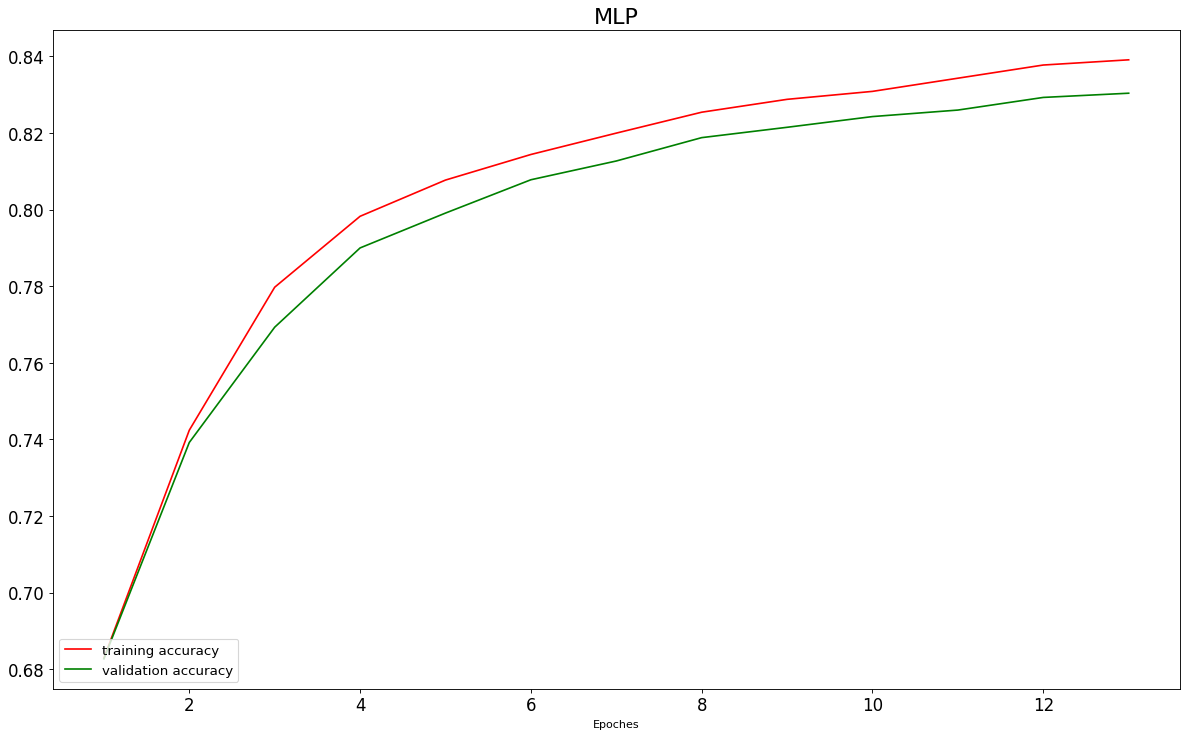

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24), dpi=80)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
x_axis = list(range(len(results_dict["train_acc"]) + 1)[1:])

plt.subplot(2,2,1)
plt.title("MLP", fontsize=20)
plt.plot(x_axis,results_dict["train_acc"],label="training accuracy",color="red")

plt.subplot(2,2,1)
plt.plot(x_axis,results_dict["val_acc"], markevery=[56], label="validation accuracy",color="green")
# plt.plot(i, acc, marker='*', color='green', label='best accuracy')

plt.xlabel("Accuracy")
plt.xlabel("Epoches")
plt.legend(loc=3, fontsize=12)


plt.show()

Choose an optimal number of epochs based on validation data

In [ ]:
optimizer = GradientDescent(learning_rate=0.00005,max_iters=1000, batch_size=50) # will stop optimizing after 1 epoch
MLP_1L = MLP(layer_num=1,M=128,active_func="tanh")
results_dict, trained_model = run_n_epochs(MLP_1L, optimizer, 40)


run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs


In [ ]:
results_dict, trained_model = run_n_epochs(trained_model, optimizer, 10, results_dict)
results_dict

run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs


{'train_acc': [0.67644,
  0.74144,
  0.77834,
  0.79672,
  0.80614,
  0.81316,
  0.81914,
  0.82406,
  0.82814,
  0.83178,
  0.83446,
  0.83718,
  0.84054,
  0.842,
  0.84412,
  0.84648,
  0.8479,
  0.84976,
  0.85164,
  0.85262,
  0.85342,
  0.85492,
  0.85658,
  0.85636,
  0.85768,
  0.85818,
  0.85962,
  0.8612,
  0.86128,
  0.86358,
  0.8635,
  0.86476,
  0.86512,
  0.86528,
  0.86712,
  0.86744,
  0.86732,
  0.86852,
  0.8689,
  0.8698,
  0.87084,
  0.87076,
  0.87126,
  0.87068,
  0.87286,
  0.87258,
  0.87306,
  0.87432,
  0.87486,
  0.87576],
 'val_acc': [0.6769,
  0.7457,
  0.7816,
  0.8031,
  0.8125,
  0.8211,
  0.8237,
  0.8293,
  0.8324,
  0.836,
  0.8385,
  0.8417,
  0.8425,
  0.8449,
  0.8465,
  0.8475,
  0.8497,
  0.8494,
  0.8507,
  0.8523,
  0.852,
  0.8529,
  0.8531,
  0.8532,
  0.855,
  0.8533,
  0.8559,
  0.8565,
  0.8572,
  0.8584,
  0.8582,
  0.8608,
  0.8594,
  0.8599,
  0.8598,
  0.8611,
  0.8604,
  0.8607,
  0.8613,
  0.8617,
  0.8617,
  0.8627,
  0.8633,
  0.8

In [ ]:
results_dict["val_acc"]

[0.6769,
 0.7457,
 0.7816,
 0.8031,
 0.8125,
 0.8211,
 0.8237,
 0.8293,
 0.8324,
 0.836,
 0.8385,
 0.8417,
 0.8425,
 0.8449,
 0.8465,
 0.8475,
 0.8497,
 0.8494,
 0.8507,
 0.8523,
 0.852,
 0.8529,
 0.8531,
 0.8532,
 0.855,
 0.8533,
 0.8559,
 0.8565,
 0.8572,
 0.8584,
 0.8582,
 0.8608,
 0.8594,
 0.8599,
 0.8598,
 0.8611,
 0.8604,
 0.8607,
 0.8613,
 0.8617,
 0.8617,
 0.8627,
 0.8633,
 0.8624,
 0.8647,
 0.8626,
 0.8626,
 0.8659,
 0.8636,
 0.8653]

<ipython-input-42-a498463e5815>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,1)


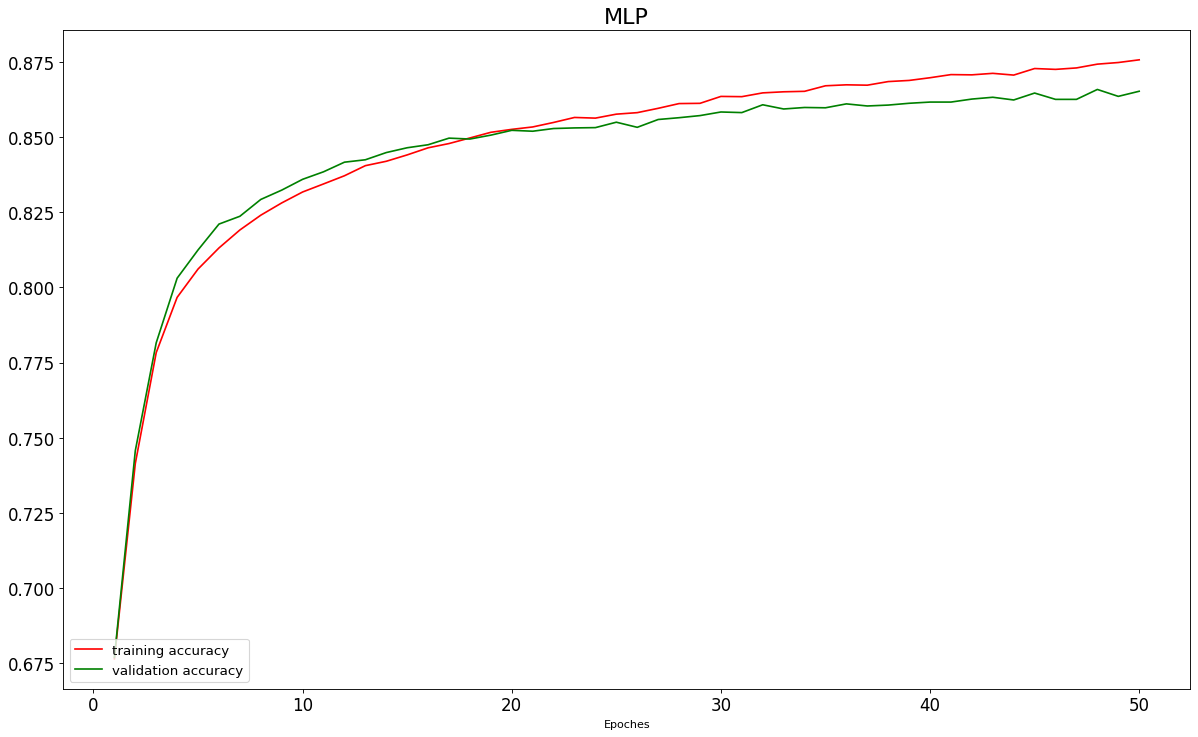

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24), dpi=80)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
x_axis = list(range(len(results_dict["train_acc"]) + 1)[1:])

plt.subplot(2,2,1)
plt.title("MLP", fontsize=20)
plt.plot(x_axis,results_dict["train_acc"],label="training accuracy",color="red")

plt.subplot(2,2,1)
plt.plot(x_axis,results_dict["val_acc"], markevery=[56], label="validation accuracy",color="green")
# plt.plot(i, acc, marker='*', color='green', label='best accuracy')

plt.xlabel("Accuracy")
plt.xlabel("Epoches")
plt.legend(loc=3, fontsize=12)



plt.show()

We chose 40 epochs because validation data had mostly plateaued. Marginal gains from higher numbers of epochs were outweighed by prohibitively large runtimes

Test for the best dropout rate

In [ ]:
optimizer = GradientDescent(learning_rate=0.00005,max_iters=1000, batch_size=50) # will stop optimizing after 1 epoch
MLP_d9 = MLP(layer_num=1,M=128,active_func="tanh", dropout=0.9)
results_dict_d9, trained_model_d9 = run_n_epochs(MLP_d9, optimizer, 20)

run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs


In [ ]:
# results_dict_d9

In [ ]:
optimizer = GradientDescent(learning_rate=0.00005,max_iters=1000, batch_size=50) # will stop optimizing after 1 epoch
MLP_d7 = MLP(layer_num=1,M=128,active_func="tanh", dropout=0.7)
results_dict_d7, trained_model_d7 = run_n_epochs(MLP_d7, optimizer, 20)

run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs
run completed after 1000 SGD batches and 1 epochs


In [ ]:
optimizer = GradientDescent(learning_rate=0.00005,max_iters=1000, batch_size=50) # will stop optimizing after 1 epoch
MLP_d5 = MLP(layer_num=1,M=128,active_func="tanh", dropout=0.7)
results_dict_d5, trained_model_d5 = run_n_epochs(MLP_1L, optimizer, 20)

In [ ]:
best_d10 = results_dict["val_acc"][10]
print(f"best accuracy for dropout 1.0: {best_d10}")
best_d9 = results_dict_d9["val_acc"][-1]
print(f"best accuracy for dropout 0.9: {best_d9}")
best_d7 = results_dict_d7["val_acc"][-1]
print(f"best accuracy for dropout 0.7: {best_d7}")

best accuracy for dropout 1.0: 0.8385
best accuracy for dropout 0.9: 0.7755
best accuracy for dropout 0.7: 0.7456


# **Task 3.6** (part 2)

In [ ]:
# train MLP with 5 epoches (with the best performance hyper parameters)
optimizer = GradientDescent(learning_rate=0.00035,max_iters=5000) 
def get_acc_history(layer_num,active_func,dropout,epoch,optimizer):
  model = MLP(layer_num=layer_num,active_func=active_func,dropout=dropout)
  result_dict = {
      'test_acc':[],
      'train_acc':[]
  }
  params = []
  for i in range(epoch):
    model.fit(x_train,y_train_mtx,optimizer,params)
    params = model.params
    test_acc = model.evaluate_acc(model.predict(x_test),y_test_mtx)
    train_acc = model.evaluate_acc(model.predict(x_train),y_train_mtx)
    result_dict['test_acc'].append(test_acc)
    result_dict['train_acc'].append(train_acc)
  return result_dict

In [ ]:
MLP_history = get_acc_history(1,"tanh",0.85,5,optimizer)
MLP_history

{'test_acc': [0.6494,
  0.7014,
  0.7491,
  0.7731,
  0.7911,
  0.7994,
  0.807,
  0.8122,
  0.8168,
  0.8192,
  0.8221,
  0.8251,
  0.827,
  0.8262,
  0.8294,
  0.8293,
  0.8318,
  0.8323,
  0.8335,
  0.8345,
  0.8353,
  0.8366,
  0.8392,
  0.8374,
  0.8368,
  0.8388,
  0.8412,
  0.8409,
  0.842,
  0.8412,
  0.8418,
  0.8419,
  0.8418,
  0.8425,
  0.8427,
  0.8435,
  0.8454,
  0.8439,
  0.8454,
  0.8452],
 'train_acc': [0.65652,
  0.71448,
  0.764,
  0.7892,
  0.80376,
  0.81186,
  0.81894,
  0.8251,
  0.8287,
  0.83244,
  0.83546,
  0.8395,
  0.84188,
  0.8441,
  0.84636,
  0.84794,
  0.85002,
  0.85138,
  0.8526,
  0.85374,
  0.85502,
  0.85636,
  0.85776,
  0.85782,
  0.85896,
  0.85928,
  0.86184,
  0.86232,
  0.8639,
  0.86458,
  0.86456,
  0.86576,
  0.86514,
  0.86758,
  0.86766,
  0.86782,
  0.86904,
  0.86836,
  0.86936,
  0.86954]}

In [ ]:
CNN_history = history.history
CNN_history

{'loss': [0.5297771692276001,
  0.3370301425457001,
  0.29407012462615967,
  0.26155945658683777,
  0.24005454778671265,
  0.22047869861125946,
  0.2015756368637085,
  0.18727506697177887,
  0.173338383436203,
  0.15733174979686737,
  0.14691777527332306,
  0.1331133097410202,
  0.12115456163883209,
  0.11122047901153564,
  0.10137778520584106,
  0.0916445180773735,
  0.08004524558782578,
  0.07295011729001999,
  0.06917434185743332,
  0.06192661076784134,
  0.05963107943534851,
  0.049003966152668,
  0.04487963020801544,
  0.0461064949631691,
  0.04220762103796005,
  0.039963629096746445,
  0.03451022505760193,
  0.030768943950533867,
  0.03765439987182617,
  0.02733081579208374,
  0.02734646387398243,
  0.025522593408823013,
  0.02635270357131958,
  0.027049105614423752,
  0.020664839074015617,
  0.02672591060400009,
  0.023782379925251007,
  0.024747375398874283,
  0.015463645569980145,
  0.02322162128984928],
 'accuracy': [0.8061041831970215,
  0.878083348274231,
  0.89189583063125

<ipython-input-83-8827414779c1>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,1)


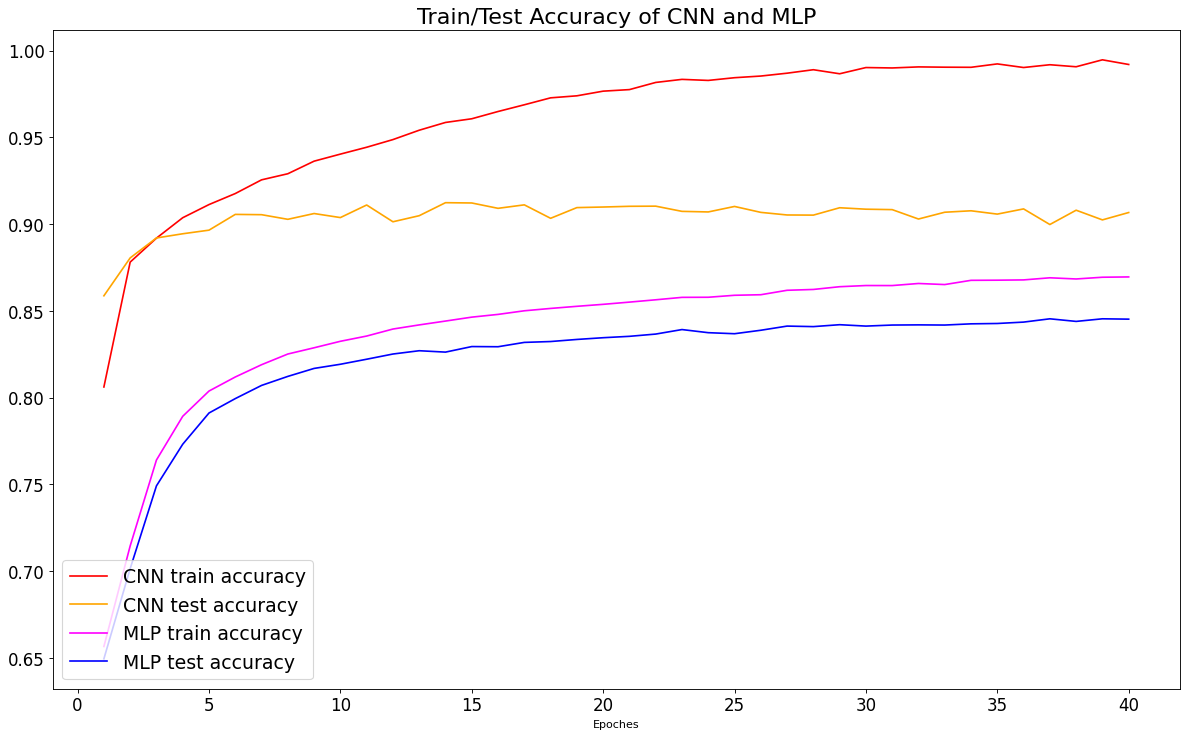

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24), dpi=80)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
c = ['red','orange','magenta','blue','navy','green','turquoise','darkviolet',
     'gray','violet','lime','gold','indianred'] 
accuracy_list = [CNN_history['accuracy'],CNN_history['val_accuracy'],MLP_history['train_acc'],MLP_history['test_acc']]
label_list = ["CNN train accuracy","CNN test accuracy","MLP train accuracy","MLP test accuracy"]
x_axis = range(41)[1:]
for i in range(4):
    plt.subplot(2,2,1)
    
    plt.title("Train/Test Accuracy of CNN and MLP", fontsize=20)
    plt.plot(x_axis,accuracy_list[i],label=label_list[i],color=c[i])
    
    plt.xlabel("Epoches")
    plt.legend(loc=3, fontsize=17)

plt.show()